In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score


In [2]:
test_data=pd.read_csv('GUIDE_Test.csv', nrows=50000)
test_data
print(list(test_data.columns))
pd.set_option('display.max_columns', None)
print(test_data.shape)
test_data.head(1)

['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City', 'Usage']
(50000, 46)


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private


In [3]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  50000 non-null  int64  
 1   OrgId               50000 non-null  int64  
 2   IncidentId          50000 non-null  int64  
 3   AlertId             50000 non-null  int64  
 4   Timestamp           50000 non-null  object 
 5   DetectorId          50000 non-null  int64  
 6   AlertTitle          50000 non-null  int64  
 7   Category            50000 non-null  object 
 8   MitreTechniques     22334 non-null  object 
 9   IncidentGrade       50000 non-null  object 
 10  ActionGrouped       21 non-null     object 
 11  ActionGranular      21 non-null     object 
 12  EntityType          50000 non-null  object 
 13  EvidenceRole        50000 non-null  object 
 14  DeviceId            50000 non-null  int64  
 15  Sha256              50000 non-null  int64  
 16  IpAd

In [4]:
#Null Columns and duplicates removal 
test_data=test_data.dropna(thresh=len(test_data)* 0.5,axis=1)
print(test_data.shape)
print(test_data.duplicated().sum())
test_data.drop_duplicates(inplace=True)
test_data.isnull().sum()

(50000, 36)
38


Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Usage                 0
dtype: int64

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49962 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  49962 non-null  int64 
 1   OrgId               49962 non-null  int64 
 2   IncidentId          49962 non-null  int64 
 3   AlertId             49962 non-null  int64 
 4   Timestamp           49962 non-null  object
 5   DetectorId          49962 non-null  int64 
 6   AlertTitle          49962 non-null  int64 
 7   Category            49962 non-null  object
 8   IncidentGrade       49962 non-null  object
 9   EntityType          49962 non-null  object
 10  EvidenceRole        49962 non-null  object
 11  DeviceId            49962 non-null  int64 
 12  Sha256              49962 non-null  int64 
 13  IpAddress           49962 non-null  int64 
 14  Url                 49962 non-null  int64 
 15  AccountSid          49962 non-null  int64 
 16  AccountUpn          49962 n

In [6]:
#Filling the NaN values for the IncidentGrade
test_data['IncidentGrade'] = test_data['IncidentGrade'].fillna(test_data['IncidentGrade'].mode()[0])
test_data['IncidentGrade'].unique()

array(['BenignPositive', 'FalsePositive', 'TruePositive'], dtype=object)

In [7]:
#Handling DateTimes
test_data['Timestamp']=pd.to_datetime(test_data['Timestamp']) # data clean Timestamp
test_data["Day"]=test_data["Timestamp"].dt.day
test_data["Month"]=test_data["Timestamp"].dt.month
test_data["Year"]=test_data["Timestamp"].dt.year
test_data["Hour"]=test_data["Timestamp"].dt.hour
test_data["Time"]=test_data["Timestamp"].dt.time
test_data=test_data.drop("Timestamp",axis=1)   # doprring timestamp column
test_data.head(10)

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,14,22,3586,5,66,242,1445,10630,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,6,6,2024,17,17:42:05
5,670014899930,0,238,378946,0,0,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396,2544,3392,2558,2696,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,6,6,2024,8,08:10:50
6,1194000913330,133,105333,732769,3,4,SuspiciousActivity,BenignPositive,Machine,Impacted,593,138268,360606,160396,441377,673934,425863,453297,1794,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private,15,6,2024,4,04:06:55
7,678604832796,6,2461,1523,17,1265,Impact,BenignPositive,Ip,Related,98799,138268,10862,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,26,5,2024,11,11:48:38
8,618475292265,7,5177,1815,21,528,Impact,FalsePositive,Ip,Related,98799,138268,128,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,25,5,2024,17,17:57:20
9,438086667998,100,7060,9787,72,53,Impact,BenignPositive,Ip,Related,98799,138268,473,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public,2,6,2024,5,05:46:22


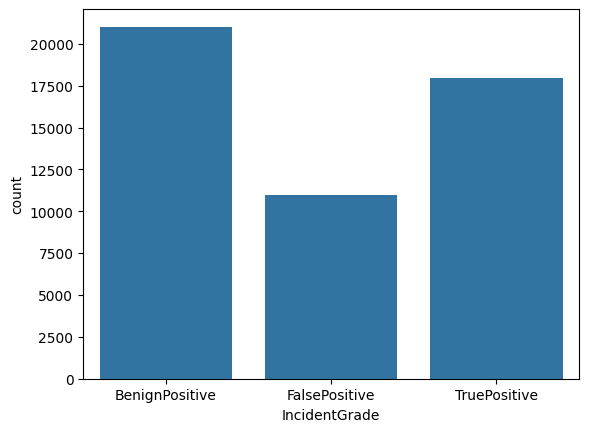

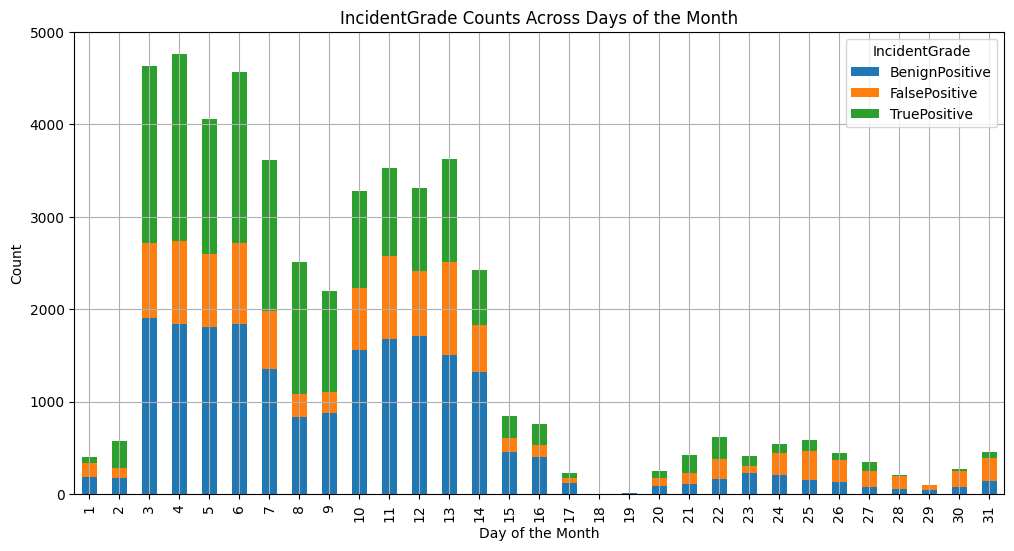

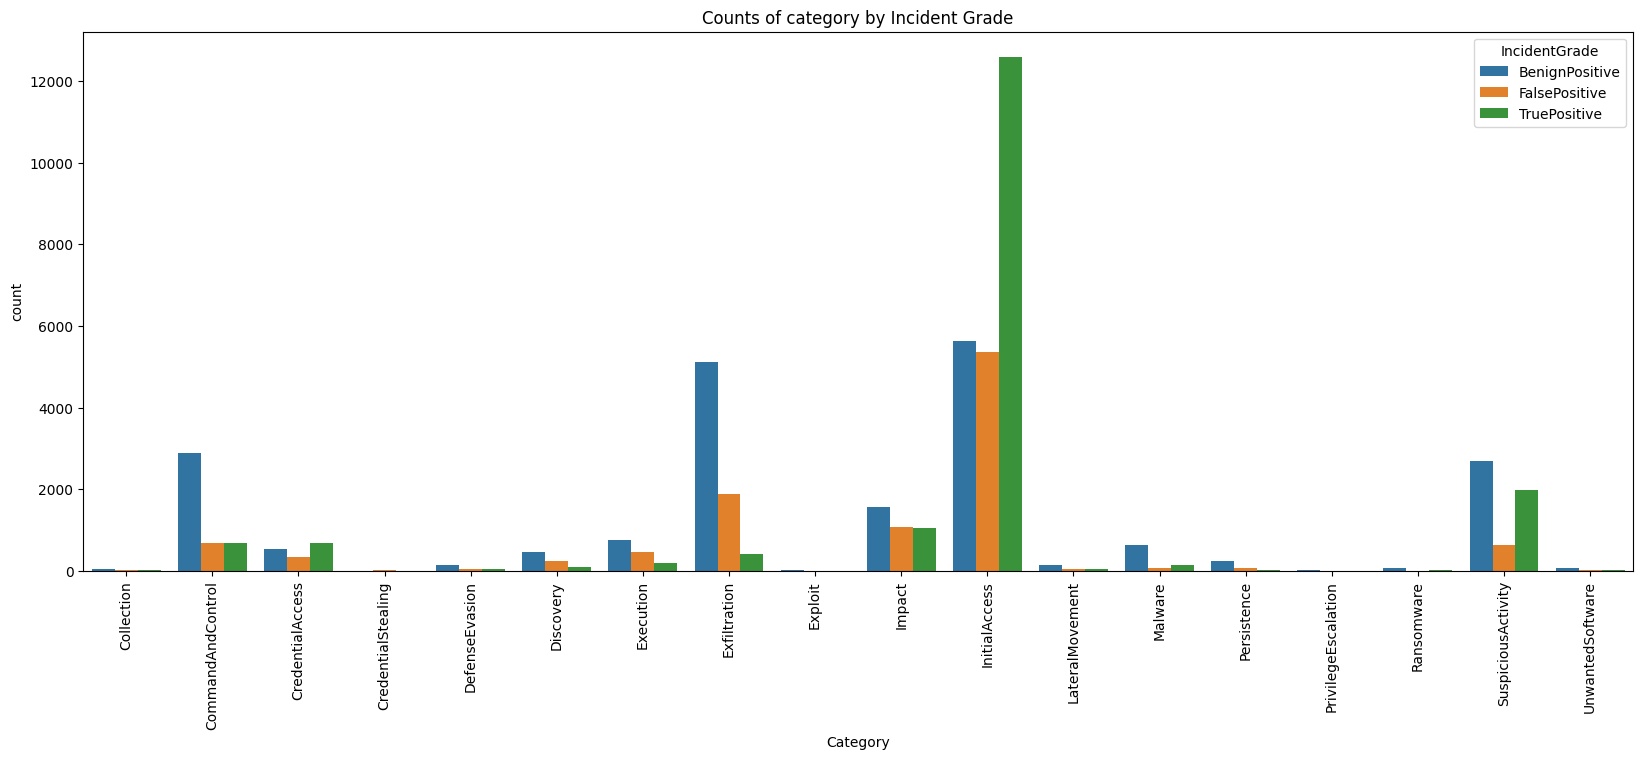

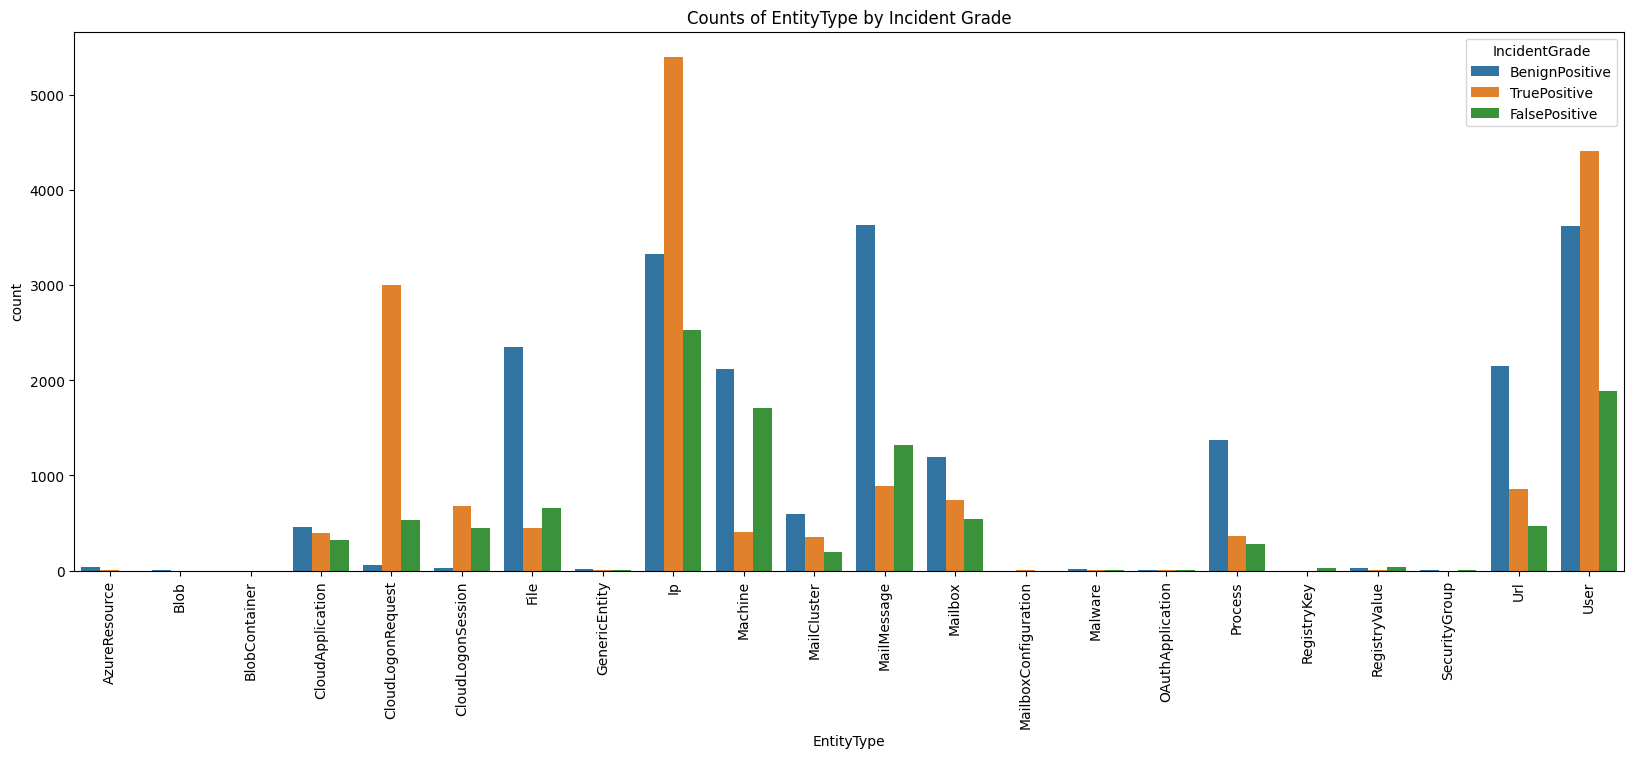

In [8]:
#Data Visualization

sns.countplot(x="IncidentGrade", data=test_data)
plt.show()

day_incident_grade = test_data.groupby(['Day', 'IncidentGrade']).size().unstack()
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

category_incident=test_data.groupby(["Category","IncidentGrade"]).size().reset_index(name="count")
plt.figure(figsize=(20,7))
sns.barplot(data=category_incident,x="Category", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of category by Incident Grade")
plt.show()

entity_incident=test_data.groupby(["EntityType","IncidentGrade"]).size().reset_index(name="count")
plt.figure(figsize=(20,7))
sns.barplot(data=entity_incident,x="EntityType", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of EntityType by Incident Grade")
plt.show()

In [9]:
test_data=test_data.drop(["Month","DeviceName","DeviceId","ResourceIdName","OAuthApplicationId","NetworkMessageId"], axis =1)
test_data.isna().sum()

Id                   0
OrgId                0
IncidentId           0
AlertId              0
DetectorId           0
AlertTitle           0
Category             0
IncidentGrade        0
EntityType           0
EvidenceRole         0
Sha256               0
IpAddress            0
Url                  0
AccountSid           0
AccountUpn           0
AccountObjectId      0
AccountName          0
RegistryKey          0
RegistryValueName    0
RegistryValueData    0
ApplicationId        0
ApplicationName      0
FileName             0
FolderPath           0
OSFamily             0
OSVersion            0
CountryCode          0
State                0
City                 0
Usage                0
Day                  0
Year                 0
Hour                 0
Time                 0
dtype: int64

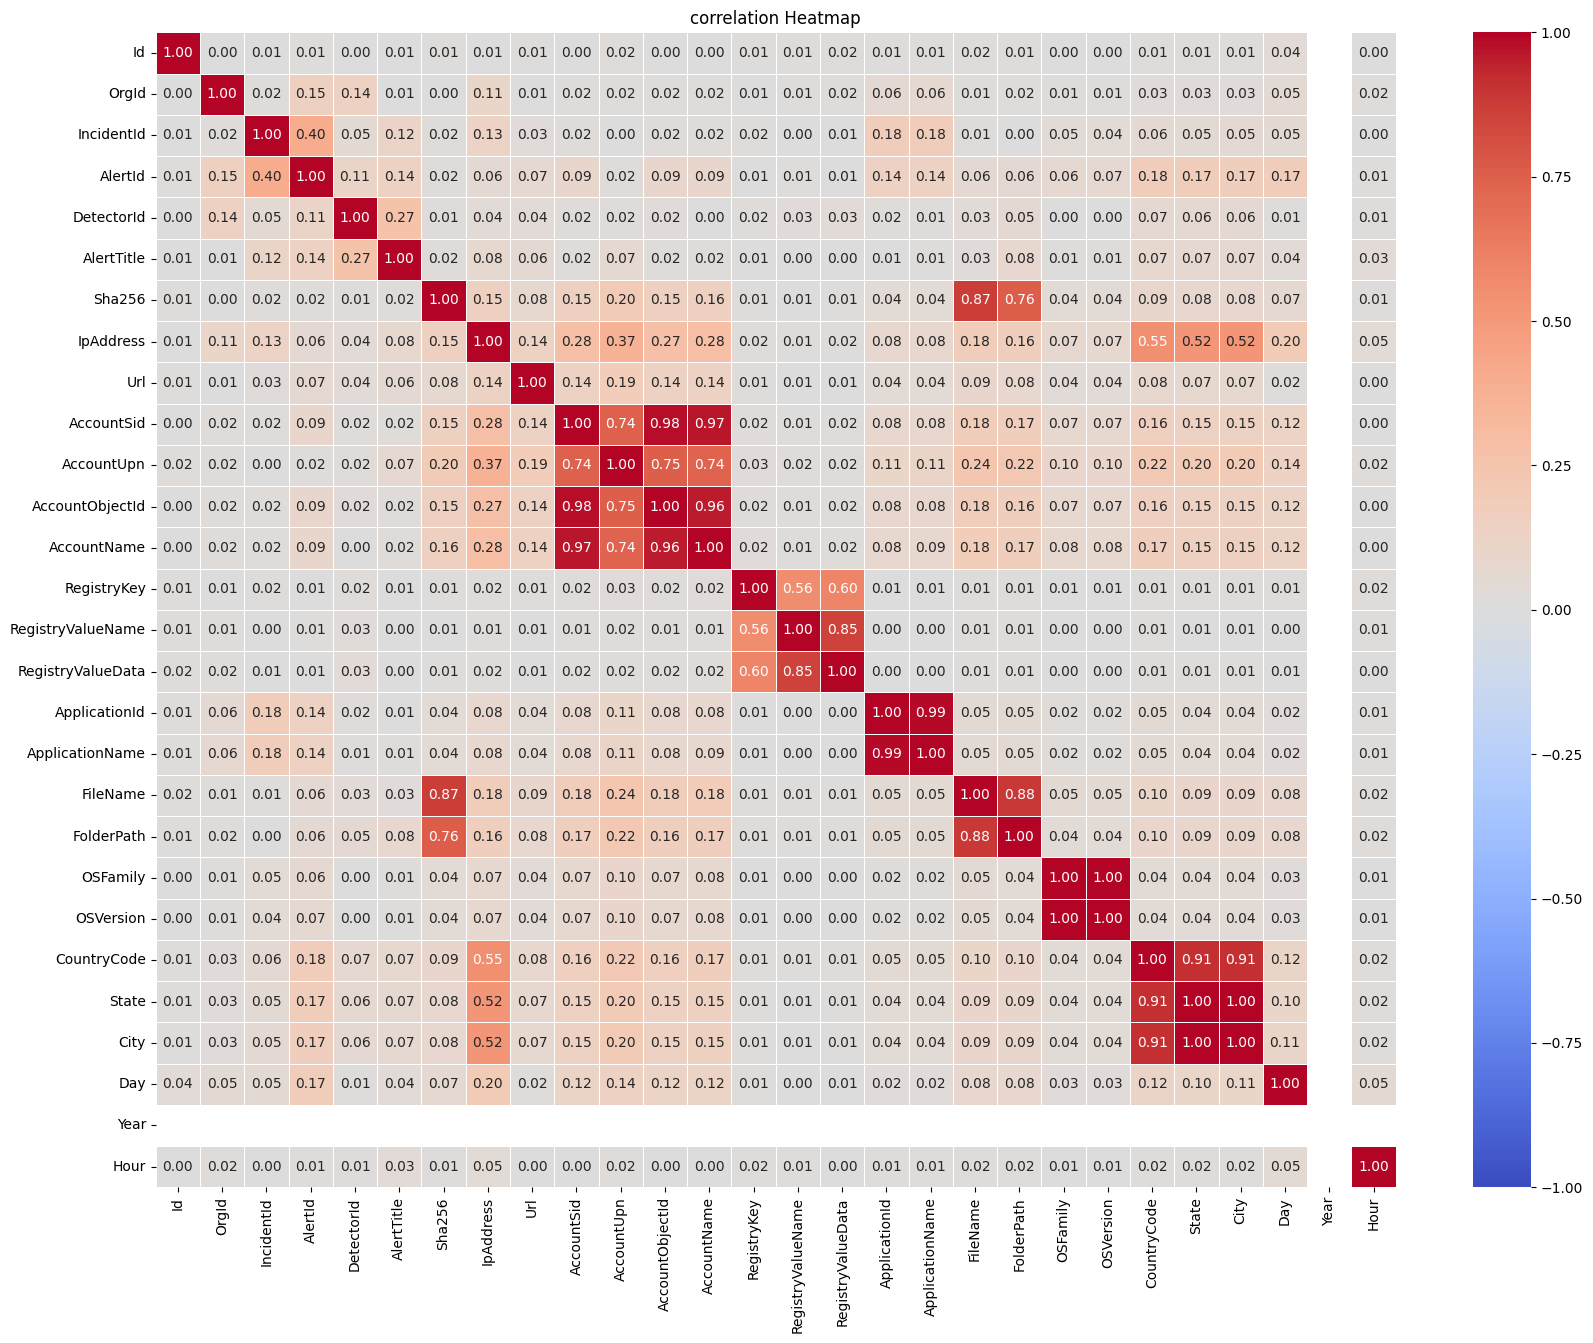

In [10]:
#Feature Selection

numeric_test_data=test_data.select_dtypes(include=['number'])
corr_matrix= numeric_test_data.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [11]:
test_data=test_data.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","AccountObjectId","FolderPath","AccountUpn"
               ,"RegistryKey","RegistryValueData","DetectorId","Id","OSFamily","OSVersion",'State',"FileName","AccountName"]
               , axis =1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49962 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OrgId          49962 non-null  int64 
 1   IncidentId     49962 non-null  int64 
 2   AlertId        49962 non-null  int64 
 3   AlertTitle     49962 non-null  int64 
 4   Category       49962 non-null  object
 5   IncidentGrade  49962 non-null  object
 6   EntityType     49962 non-null  object
 7   EvidenceRole   49962 non-null  object
 8   IpAddress      49962 non-null  int64 
 9   Url            49962 non-null  int64 
 10  ApplicationId  49962 non-null  int64 
 11  City           49962 non-null  int64 
 12  Usage          49962 non-null  object
 13  Day            49962 non-null  int32 
 14  Year           49962 non-null  int32 
 15  Hour           49962 non-null  int32 
 16  Time           49962 non-null  object
dtypes: int32(3), int64(8), object(6)
memory usage: 6.3+ MB


In [12]:
#Encoding

categorical_columns=test_data.select_dtypes(include=["object"]).columns
encoders=[]
for i in categorical_columns:
    label_encoder = LabelEncoder()
    test_data[i]=label_encoder.fit_transform(test_data[i])
    mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
    encoders.append(mapping)
    print(mapping)
encoders

{'Collection': 0, 'CommandAndControl': 1, 'CredentialAccess': 2, 'CredentialStealing': 3, 'DefenseEvasion': 4, 'Discovery': 5, 'Execution': 6, 'Exfiltration': 7, 'Exploit': 8, 'Impact': 9, 'InitialAccess': 10, 'LateralMovement': 11, 'Malware': 12, 'Persistence': 13, 'PrivilegeEscalation': 14, 'Ransomware': 15, 'SuspiciousActivity': 16, 'UnwantedSoftware': 17}
{'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2}
{'AzureResource': 0, 'Blob': 1, 'BlobContainer': 2, 'CloudApplication': 3, 'CloudLogonRequest': 4, 'CloudLogonSession': 5, 'File': 6, 'GenericEntity': 7, 'Ip': 8, 'Machine': 9, 'MailCluster': 10, 'MailMessage': 11, 'Mailbox': 12, 'MailboxConfiguration': 13, 'Malware': 14, 'OAuthApplication': 15, 'Process': 16, 'RegistryKey': 17, 'RegistryValue': 18, 'SecurityGroup': 19, 'Url': 20, 'User': 21}
{'Impacted': 0, 'Related': 1}
{'Private': 0, 'Public': 1}
{datetime.time(0, 0, 2): 0, datetime.time(0, 0, 6): 1, datetime.time(0, 0, 7): 2, datetime.time(0, 0, 9): 3, datetime.time(

[{'Collection': 0,
  'CommandAndControl': 1,
  'CredentialAccess': 2,
  'CredentialStealing': 3,
  'DefenseEvasion': 4,
  'Discovery': 5,
  'Execution': 6,
  'Exfiltration': 7,
  'Exploit': 8,
  'Impact': 9,
  'InitialAccess': 10,
  'LateralMovement': 11,
  'Malware': 12,
  'Persistence': 13,
  'PrivilegeEscalation': 14,
  'Ransomware': 15,
  'SuspiciousActivity': 16,
  'UnwantedSoftware': 17},
 {'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2},
 {'AzureResource': 0,
  'Blob': 1,
  'BlobContainer': 2,
  'CloudApplication': 3,
  'CloudLogonRequest': 4,
  'CloudLogonSession': 5,
  'File': 6,
  'GenericEntity': 7,
  'Ip': 8,
  'Machine': 9,
  'MailCluster': 10,
  'MailMessage': 11,
  'Mailbox': 12,
  'MailboxConfiguration': 13,
  'Malware': 14,
  'OAuthApplication': 15,
  'Process': 16,
  'RegistryKey': 17,
  'RegistryValue': 18,
  'SecurityGroup': 19,
  'Url': 20,
  'User': 21},
 {'Impacted': 0, 'Related': 1},
 {'Private': 0, 'Public': 1},
 {datetime.time(0, 0, 2): 0,
  dateti

In [13]:
test_data
test_data.to_csv('test_data_process.csv',index= False)

In [14]:
from imblearn.over_sampling import RandomOverSampler

over_sampler=RandomOverSampler(random_state = 94)
X=test_data.drop(['IncidentGrade','Usage'],axis=1)
y=test_data[['IncidentGrade']]
y.value_counts()

IncidentGrade
0                21018
2                17985
1                10959
Name: count, dtype: int64

In [15]:
X_over_sampler,y_over_sampler=over_sampler.fit_resample(X,y)
y_over_sampler.value_counts()

IncidentGrade
0                21018
1                21018
2                21018
Name: count, dtype: int64

In [16]:
#Feature Selection
X1=X_over_sampler[['OrgId', 'IncidentId', 'AlertId', 'AlertTitle', 'Day', 'Time',
       'Category', 'Hour', 'EntityType', 'IpAddress', 'City', 'Url',
       'EvidenceRole', 'ApplicationId', 'Year']]
X1

,OrgId,IncidentId,AlertId,AlertTitle,Day,Time,Category,Hour,EntityType,IpAddress,City,Url,EvidenceRole,ApplicationId,Year
0,657,11767,87199,563,4,31173,11,22,21,360606,10630,160396,0,2251,2024
1,3,91158,632273,2,3,16064,1,12,9,360606,10630,160396,0,2251,2024
2,145,32247,131719,10807,8,4072,11,3,16,360606,10630,160396,1,2251,2024
3,222,15294,917686,0,12,14799,10,12,5,360606,10630,160396,1,2251,2024
4,363,7615,5944,18,6,23539,5,17,21,360606,10630,160396,0,2251,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63049,113,4980,466830,60,6,7204,10,6,20,360606,10630,3,1,2251,2024
63050,8,24249,723438,4,9,11348,16,9,21,360606,10630,160396,0,2251,2024
63051,0,297,381621,0,5,8670,10,7,21,360606,10630,160396,0,2251,2024
63052,49,23495,774509,2,16,31780,1,23,9,360606,10630,160396,0,2251,2024


In [17]:
#Model Building

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted)
    prec = precision_score(actual, predicted, average="macro")
    recall = recall_score(actual, predicted, average="macro")
    macro_f1 = f1_score(actual, predicted, average="macro")
    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

X_train,X_test,y_train,y_test = train_test_split(X1,y_over_sampler, test_size = 0.20, random_state = 43)

In [18]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")
dt_model.fit(X_train,y_train)
train_dt_pred =dt_model.predict(X_train)
test_dt_pred =dt_model.predict(X_test)
dttrain_metrics=metrics(y_train,train_dt_pred)
dttest_metrics=metrics(y_test,test_dt_pred)

dt_metrics_df=pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()
dt_metrics_df

,Metrics,Training,Testing
0,Accuracy,0.661122,0.660534
1,Precision,0.699994,0.700987
2,Recall,0.661220,0.660117
3,Macro F1,0.666219,0.665148


In [19]:
rfc_model =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)
rfc_model.fit(X_train,y_train)
train_rfc_pred =rfc_model.predict(X_train)
test_rfc_pred =rfc_model.predict(X_test)
rfc_train_metrics=metrics(y_train,train_rfc_pred)
rfc_test_metrics=metrics(y_test,test_rfc_pred)

rfc_metrics_df=pd.DataFrame({
    "Training":rfc_train_metrics["Values"],
    "Testing":rfc_test_metrics["Values"]
}).reset_index()
rfc_metrics_df

c:\Users\mypc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Metrics,Training,Testing
0,Accuracy,0.796007,0.785029
1,Precision,0.851990,0.843731
2,Recall,0.796183,0.784286
3,Macro F1,0.800594,0.789289


In [20]:
xgb_model =xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)
xgb_model.fit(X_train,y_train)
train_xgb_pred =xgb_model.predict(X_train)
test_xgb_pred =xgb_model.predict(X_test)
xgb_train_metrics=metrics(y_train,train_xgb_pred)
xgb_test_metrics=metrics(y_test,test_xgb_pred)

xgb_metrics_df=pd.DataFrame({
    "Training":xgb_train_metrics["Values"],
    "Testing":xgb_test_metrics["Values"]
}).reset_index()
xgb_metrics_df

,Metrics,Training,Testing
0,Accuracy,0.966517,0.925541
1,Precision,0.966749,0.926537
2,Recall,0.966511,0.925614
3,Macro F1,0.966539,0.925682


In [21]:
import pickle
with open('xgb_classifier_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

print("Model has been pickled successfully.")

Model has been pickled successfully.
